# Вебинар 6. Двухуровневые модели рекомендаций


Код для src, utils, metrics вы можете скачать из [этого](https://github.com/geangohn/recsys-tutorial) github репозитория

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Для работы с матрицами
from scipy.sparse import csr_matrix

# Матричная факторизация
from implicit import als

# Модель второго уровня
from lightgbm import LGBMClassifier

import os, sys
module_path = os.path.abspath(os.path.join(os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

# Написанные нами функции
from git_raw.metrics import precision_at_k, recall_at_k
from git_raw.utils import prefilter_items
from git_raw.recommenders import MainRecommender

In [2]:
data = pd.read_csv('git_raw/data/retail_train_sample.csv')
item_features = pd.read_csv('git_raw/data/product.csv')
user_features = pd.read_csv('git_raw/data/hh_demographic.csv')

# column processing
item_features.columns = [col.lower() for col in item_features.columns]
user_features.columns = [col.lower() for col in user_features.columns]

item_features.rename(columns={'product_id': 'item_id'}, inplace=True)
user_features.rename(columns={'household_key': 'user_id'}, inplace=True)


# Важна схема обучения и валидации!
# -- давние покупки -- | -- 6 недель -- | -- 3 недель -- 
# подобрать размер 2-ого датасета (6 недель) --> learning curve (зависимость метрики recall@k от размера датасета)
val_lvl_1_size_weeks = 6
val_lvl_2_size_weeks = 3

data_train_lvl_1 = data[data['week_no'] < data['week_no'].max() - (val_lvl_1_size_weeks + val_lvl_2_size_weeks)]
data_val_lvl_1 = data[(data['week_no'] >= data['week_no'].max() - (val_lvl_1_size_weeks + val_lvl_2_size_weeks)) &
                      (data['week_no'] < data['week_no'].max() - (val_lvl_2_size_weeks))]

data_train_lvl_2 = data_val_lvl_1.copy()  # Для наглядности. Далее мы добавим изменения, и они будут отличаться
data_val_lvl_2 = data[data['week_no'] >= data['week_no'].max() - val_lvl_2_size_weeks]

data_train_lvl_1.head(2)

,Unnamed: 0,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,1832874,1078,35573861879,524,1082185,1,0.56,375,0.0,1440,76,0.0,0.0
1,402281,324,29170411703,165,7168774,2,6.98,367,0.0,1115,24,0.0,0.0


In [3]:
n_items_before = data_train_lvl_1['item_id'].nunique()

data_train_lvl_1 = prefilter_items(data_train_lvl_1, item_features=item_features, take_n_popular=5000)

n_items_after = data_train_lvl_1['item_id'].nunique()
print('Decreased # items from {} to {}'.format(n_items_before, n_items_after))

Decreased # items from 33411 to 5001


In [4]:
recommender = MainRecommender(data_train_lvl_1)

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/5001 [00:00<?, ?it/s]

In [5]:
recommender.get_als_recommendations(2375, N=5)

[1065167, 8203599, 995120, 847738, 986021]

In [6]:
recommender.get_own_recommendations(2375, N=5)

[13158780, 995120, 973181, 890719, 986021]

In [7]:
recommender.get_similar_items_recommendation(2375, N=5)

[1042907, 12810393, 1119667, 12263692, 995120]

In [8]:
recommender.get_similar_users_recommendation(2375, N=5)

[938596, 5707857, 1019387, 5707857, 959343]

### Задание 1

A) Попробуйте различные варианты генерации кандидатов. Какие из них дают наибольший recall@k ?
- Пока пробуем отобрать 50 кандидатов (k=50)
- Качество измеряем на data_val_lvl_1: следующие 6 недель после трейна

Дают ли own recommendtions + top-popular лучший recall?  

B)* Как зависит recall@k от k? Постройте для одной схемы генерации кандидатов эту зависимость для k = {20, 50, 100, 200, 500}  
C)* Исходя из прошлого вопроса, как вы думаете, какое значение k является наиболее разумным?


In [9]:
result = data_val_lvl_1.groupby('user_id')['item_id'].unique().reset_index()
result.columns=['user_id', 'actual']
result.head(2)

,user_id,actual
0,1,"[1098248, 1017299, 1077430, 938004, 1082185, 8..."
1,2,"[830127, 7442008, 899624, 944568]"


In [12]:
%%time
result[f'get_similar_items_recommendation'] = result['user_id'].apply(lambda x: recommender.get_similar_items_recommendation(x, N=500))
result.head(2)

Wall time: 5.8 s


,user_id,actual,get_similar_items_recommendation
0,1,"[1098248, 1017299, 1077430, 938004, 1082185, 8...","[824758, 1109465, 12946257, 1132789, 878285, 8..."
1,2,"[830127, 7442008, 899624, 944568]","[1043751, 863885, 43020, 12524691, 1127831, 86..."


In [13]:
stats = pd.DataFrame().reindex([5, 10, 20, 50, 100, 200, 500])
stats.index.name = 'K'

In [15]:
stat = dict()
for i in [5, 10, 20, 50, 100, 200, 500]:
    stat.update({i: result.apply(lambda row: precision_at_k(row[f'get_similar_items_recommendation'], row['actual'], k=i), axis=1).mean()})
stats['get_similar_items_recommendation'] = stats.index.map(stat)
stats

,get_similar_items_recommendation
K,
5,0.011111
10,0.008805
20,0.007547
50,0.006876
100,0.005398
200,0.004274
500,0.002449


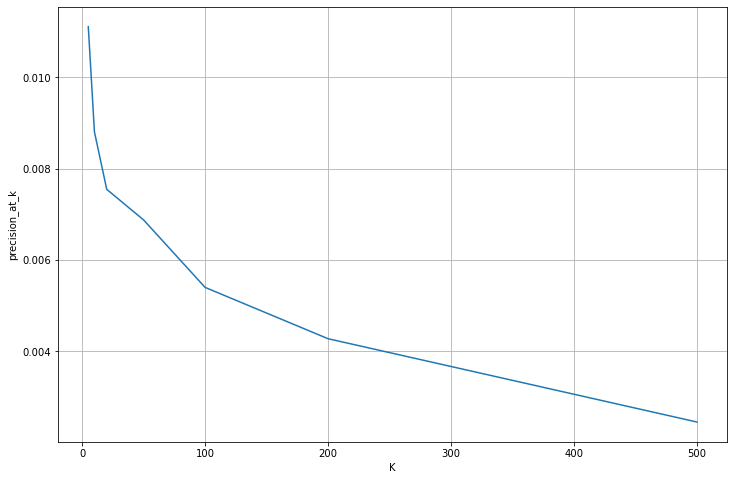

In [16]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(figsize=(12, 8))

ax.plot(stats)
ax.grid()

ax.set_xlabel('K')
ax.set_ylabel('precision_at_k')

plt.show()

Вывод: чем больше K - тем меньше precision_at_k, т.к. реально купленные товары, похоже, размываются в большом объеме рекоммендаций

Комментарий: другими методами посчатить не получилось - выдает ошибку. Пример:

In [46]:
%%time
result[f'get_own_recommendations'] = result['user_id'].apply(lambda x: recommender.get_own_recommendations(x, N=500))
result.head(2)

ValueError: userid is out of bounds of the user_items matrix

Думал связано с тем, что в валидации появляются id пользователей, которых не было в трейне. Удалил из трейна таких пользователей. Но проблема осталась (см ниже). Решения найти не смог.

In [51]:
data_train_lvl_1_5 = data[data['week_no'] < data['week_no'].max() - (val_lvl_1_size_weeks + val_lvl_2_size_weeks)]
data_train_lvl_1_5 = data_train_lvl_1_5.loc[data_train_lvl_1_5['user_id'].isin(data_val_lvl_1['user_id'].tolist())]

Переобучим все заново

In [52]:
n_items_before = data_train_lvl_1_5['item_id'].nunique()
data_train_lvl_1_5 = prefilter_items(data_train_lvl_1_5, item_features=item_features, take_n_popular=5000)
n_items_after = data_train_lvl_1_5['item_id'].nunique()
print('Decreased # items from {} to {}'.format(n_items_before, n_items_after))
recommender = MainRecommender(data_train_lvl_1_5)

Decreased # items from 31883 to 5001


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/5001 [00:00<?, ?it/s]

In [54]:
%%time
result2 = data_val_lvl_1.groupby('user_id')['item_id'].unique().reset_index()
result2.columns=['user_id', 'actual']
result2.head(2)

Wall time: 129 ms


,user_id,actual
0,1,"[1098248, 1017299, 1077430, 938004, 1082185, 8..."
1,2,"[830127, 7442008, 899624, 944568]"


In [55]:
result2[f'get_own_recommendations'] = result2['user_id'].apply(lambda x: recommender.get_own_recommendations(x, N=500))
result2.head(2)

ValueError: userid is out of bounds of the user_items matrix

### Задание 2.

Обучите модель 2-ого уровня, при этом:
    - Добавьте минимум по 2 фичи для юзера, товара и пары юзер-товар
    - Измерьте отдельно precision@5 модели 1-ого уровня и двухуровневой модели на data_val_lvl_2
    - Вырос ли precision@5 при использовании двухуровневой модели?

In [ ]:
# your_code

### Финальный проект

Мы уже прошли всю необходимуб теорию для финального проекта. Проект осуществляется на данных из вебинара (данные считаны в начале ДЗ).
Рекомендуем вам **начать делать проект сразу после этого домашнего задания**
- Целевая метрика - precision@5. Порог для уcпешной сдачи проекта precision@5 > 25%
- Будет public тестовый датасет, на котором вы сможете измерять метрику
- Также будет private тестовый датасет для измерения финального качества
- НЕ обязательно, но крайне желательно использовать 2-ух уровневые рекоммендательные системы в проекте
- Вы сдаете код проекта в виде github репозитория и csv файл с рекомендациями 